<a href="https://colab.research.google.com/github/joony0512/Deep_Learning_Class/blob/main/Part6/P6_Ch01_CH03_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Segmentation

In [1]:
import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.losses as losses


img_path: /content/drive/MyDrive/data/images/Bombay_91.jpg
mask_path: /content/drive/MyDrive/data/annotations/trimaps/Bombay_91.png


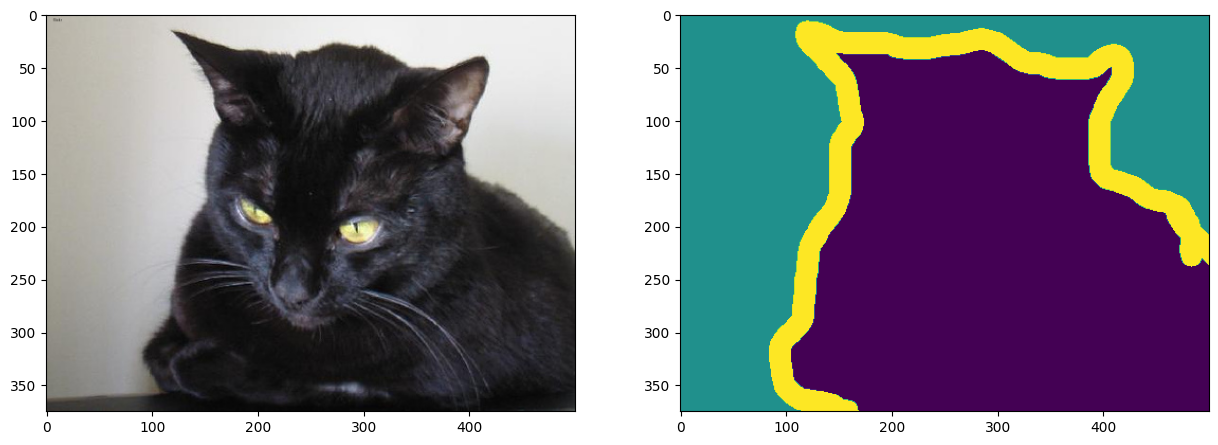

In [2]:
csv_path = '/content/drive/MyDrive/data/kfolds.csv'
df = pd.read_csv(csv_path)
idx = random.choice(range(len(df)))

file_name = df.loc[idx]['filename']
img_path = f'/content/drive/MyDrive/data/images/{file_name}.jpg'
mask_path = f'/content/drive/MyDrive/data/annotations/trimaps/{file_name}.png'

print('img_path:', img_path)
print('mask_path:', mask_path)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

assert img.shape[:2] == mask.shape[:2]
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)

plt.show()

In [3]:
import albumentations as A
import cv2

class Augmentation:
  def __init__(self, size, mode ='train'):
    if mode =='train':
      # Declare an augmentation pipeline
      self.transform = A.Compose([
          A.HorizontalFlip(p=0.5), # 좌우반전, p(적용할 확률)
          A.ShiftScaleRotate(
              p = 0.5,
              shift_limit = 0.05,
              scale_limit = 0.05,
              rotate_limit = 15,
          ), # 이동%, 확대축소%, 회전각도 제약걸기
          A.CoarseDropout(
              p = 0.5,
              max_holes =8,
              max_height = int(0.1 * size),
              max_width = int(0.1 * size),
          ),
          A.RandomBrightnessContrast(p=0.2),
      ])

  def __call__(self, **kwargs):
    if self.transform:
      aumented = self.transform(**kwargs)
      img = aumented['image']
      mask = aumented['mask']

      return img, mask


In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        batch_size,
        csv_path,
        fold,
        image_size,
        mode ='train',
        shuffle = True):

        self.batch_size = batch_size
        self.image_size = image_size
        self.fold = fold
        self.mode = mode
        self.shuffle = shuffle

        self.df = pd.read_csv(csv_path)

        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode =='val':
            self.df = self.df[self.df['fold'] == self.fold]


        ### Remove invalid files
        ### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['filename'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)

        self.on_epoch_end()


    def __len__(self):
        return math.ceil(len(self.df)/self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1)* self.batch_size
        data = self.df.iloc[strt:fin]

        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)

    def get_data(self, data):
        batch_x =[]
        batch_y =[]

        for _, r in data.iterrows():
            file_name = r['filename']

            image = cv2.imread(f'/content/drive/MyDrive/data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # input image resize (배치로 묶기위해)
            image = cv2.resize(image, (self.image_size, self.image_size))

            # mask가 Label 로 사용
            mask = cv2.imread(f'/content/drive/MyDrive/data/annotations/trimaps/{file_name}.png',
                              cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.image_size, self.image_size))
            # mask[mask != 1] =0
            mask -= 1

            if self.mode == 'train':
            #   image = image.astype('uint8')
              image, mask= self.transform(image = image,
                                     mask = mask)

            # rescaling
            image = image.astype('float32')
            image = image /255.

            mask = mask.astype('float32')

            # mask가 Label 로 사용
            batch_x.append(image)
            batch_y.append(mask)
        return batch_x, batch_y



    def on_epoch_end(self): # callback function
        if self.shuffle:
            self.df = self.df.sample(frac =1).reset_index(drop=True)

csv_path = '/content/drive/MyDrive/data/kfolds.csv'
train_generator = DataGenerator(
    batch_size = 64,
    csv_path =csv_path,
    fold = 1,
    image_size = 128,
    mode ='train',
    shuffle = True
)

val_generator = DataGenerator(
    batch_size = 64,
    csv_path =csv_path,
    fold = 1,
    image_size = 128,
    mode ='val',
    shuffle = True
)

In [5]:
!pip install keras_unet

In [6]:
#https://github.com/karolzak/keras-unet
from keras_unet.models import custom_unet

model = custom_unet(
    input_shape=(128, 128, 3),
    use_batch_norm=True,
    upsample_mode= 'deconv',
    dropout_type='spatial',
    use_attention = True,
    num_classes=3,
    filters=64,
    num_layers =4,
    dropout=0.2,
    output_activation='softmax')

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')
model.summary()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         1728      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                               

In [ ]:
history = model.fit(
    train_generator ,
    validation_data = val_generator,
    epochs = 10,
    verbose =1
)

Epoch 1/10


In [ ]:
import matplotlib.pyplot as plt
# history = history.history

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(history['loss'], label ='train')
plt.plot(history['val_loss'], label = 'val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')


In [ ]:
for images, masks in valid_generator:
  break
preds = model.predict(images)

In [ ]:
idx = random.choice(range(len(preds)))
plt.figure(figsize = (15,15))
plt.subplot(1,3,1)
plt.imshow(images[idx,...])
plt.subplot(1,3,2)
plt.imshow(mask[idx])
plt.subplot(1,3,3)
pred = np.argmax(preds[idx], axis =-1)
plt.imshow(pred)


In [ ]:
np.unique(pred)